In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on the sonar dataset with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
import time
warnings.filterwarnings("ignore")


In [169]:
heart = pd.read_csv('dataset/heart.csv')
#heart2 = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')

In [170]:
dataset = heart

In [171]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [172]:
dataset

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
297   57    0   0     140   241    0        1       123     1      0.2    1   
298   45    1   3     110   264    0        1       132     0      1.2    1   
299   68    1   0     144   193    1        1       141     0      3.4    1   
300   57    1   0     130   131    0        1       115     1      1.2    1   
301   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  
1      0      2       1  
2      0      2       1  
3      0      2       1  
4      0      2       1  
..   ...    ...     ...  
297    0      3       0  
298    0      3       0  
299    2      3       0  
300    1      3       0  
301    1      2       0  

[302 rows x 14 columns]

In [173]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [174]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

## Train the Support Vector Classifier

In [175]:
def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    roc_10 = []
    cpu_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        roc_list = []
        cpu = []
        
        for train_ix, test_ix in kfold.split(X, y):

            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            t0= time.time()
            if (param == 0):
                model = SVC(probability=True)
                
            else:
                model = SVC(C=param['C'], gamma = param['gamma'], kernel= param['kernel'],probability=True )

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            #print(predictions)
            probs = model.predict_proba(X_test)
            #print(probs)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)
        
    plt.figure(figsize=(10,6))
    plt.plot(range(0,30),accuracy_10,color='blue', linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('checking the variance in 30 iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()
   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    
    return([accu,pre,spec,rec,f1,roc,cpu])



from sklearn.model_selection import cross_validate
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
model = SVC()
list_pre = []
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'roc_auc': 'roc_auc'}
score = cross_validate(model,scaled_features,y,cv=10, scoring =scoring)
print(score['test_accuracy'].mean())


## Grid serach 

In [176]:

from sklearn.model_selection import GridSearchCV
def grid_search():
    
    param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
    grid = GridSearchCV(SVC(),param_grid,refit=True)
    # May take awhile!
    grid.fit(X_train,y_train)

    grid.best_params_
    return(grid.best_params_)


In [177]:
dict_SV = {}

## First Model without preprocessing 

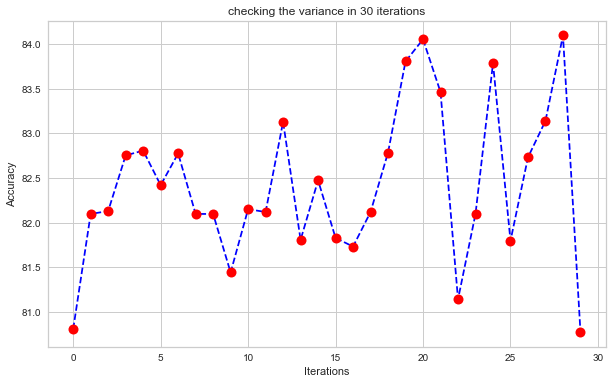

{'SVM': [82.4146953405018,
  83.61690185145926,
  81.63136202413024,
  82.4146953405018,
  82.31708194227356,
  89.87092896669783,
  0.016111489137013758]}

In [178]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['SVM'] = result
dict_SV



## Hypertune model using grid search

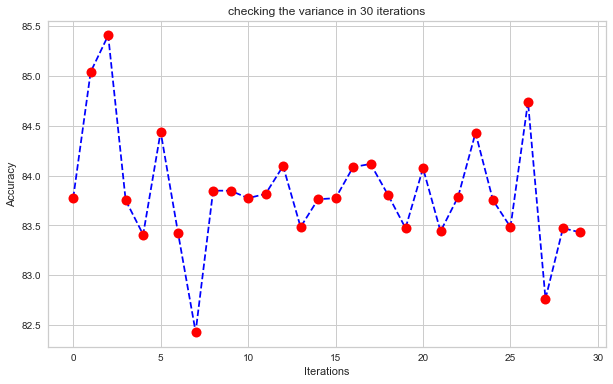

{'SVM': [82.4146953405018,
  83.61690185145926,
  81.63136202413024,
  82.4146953405018,
  82.31708194227356,
  89.87092896669783,
  0.016111489137013758],
 'Hypertuned': [83.831541218638,
  85.21377373566703,
  81.0034535633573,
  83.831541218638,
  83.58993038653384,
  90.49963522797498,
  0.011916120052337647]}

In [179]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Hypertuned'] = result
dict_SV


## PCA

In [180]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 4)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)

In [181]:
pca.explained_variance_ratio_

array([0.21313479, 0.11859478, 0.09359819, 0.09121102])

In [182]:
df_comp = pd.DataFrame(pca.components_,columns=dataset.iloc[:, 0:-1].columns)

<AxesSubplot:>

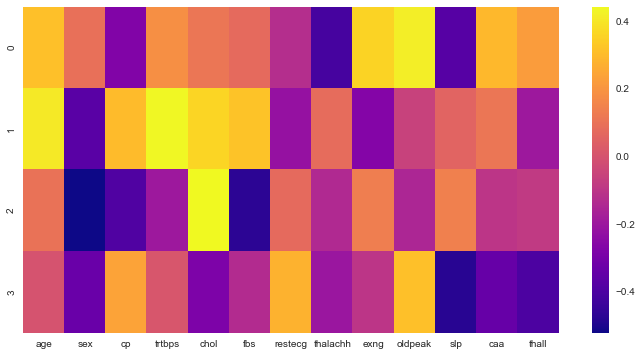

In [183]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


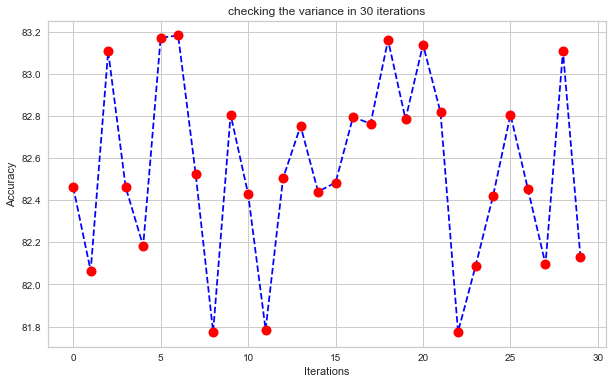

{'SVM': [82.4146953405018,
  83.61690185145926,
  81.63136202413024,
  82.4146953405018,
  82.31708194227356,
  89.87092896669783,
  0.016111489137013758],
 'Hypertuned': [83.831541218638,
  85.21377373566703,
  81.0034535633573,
  83.831541218638,
  83.58993038653384,
  90.49963522797498,
  0.011916120052337647],
 'Pca': [82.54910394265234,
  83.60669452823483,
  80.85706994295197,
  82.54910394265234,
  82.39399322864223,
  91.04546780255289,
  0.012255919774373372]}

In [184]:
X = x_pca
y = dataset.iloc[:, -1].values
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401)
param = grid_search()
print(param)
result = calculate_model(param,X,y)
dict_SV['Pca'] = result
dict_SV


## Feature Importance

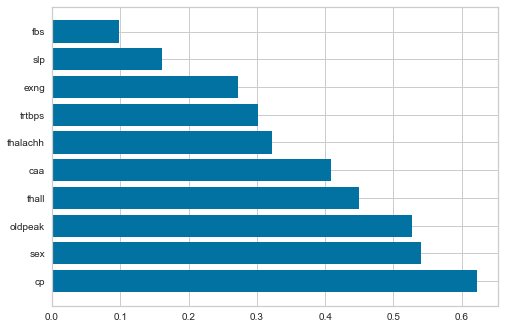

In [185]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

features_names = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh','exng', 'oldpeak', 'slp', 'caa', 'thall']
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
f_importances(abs(svm.coef_[0]), features_names, top=10)


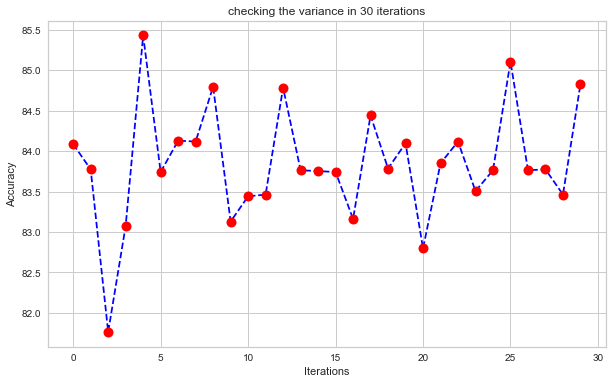

{'SVM': [82.4146953405018,
  83.61690185145926,
  81.63136202413024,
  82.4146953405018,
  82.31708194227356,
  89.87092896669783,
  0.016111489137013758],
 'Hypertuned': [83.831541218638,
  85.21377373566703,
  81.0034535633573,
  83.831541218638,
  83.58993038653384,
  90.49963522797498,
  0.011916120052337647],
 'Pca': [82.54910394265234,
  83.60669452823483,
  80.85706994295197,
  82.54910394265234,
  82.39399322864223,
  91.04546780255289,
  0.012255919774373372],
 'FImp': [83.84802867383513,
  85.11320327704819,
  82.31620049944522,
  83.84802867383513,
  83.71025263707661,
  90.56141572030317,
  0.01320926586786906]}

In [186]:

X = dataset[['cp','thall','oldpeak','caa','sex','thalachh']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['FImp'] = result
dict_SV


## Permutation Importance


In [187]:
#pip install eli5

In [188]:
import eli5
from eli5.sklearn import PermutationImportance
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC(kernel='rbf')
svc.fit(X_train, y_train) 
# create permutation importance object using model
# and fit on test set
perm = PermutationImportance(svc, random_state=1).fit(X_test, y_test)
  
# display weights using PermutationImportance object
eli5.show_weights(perm, feature_names =['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall'])

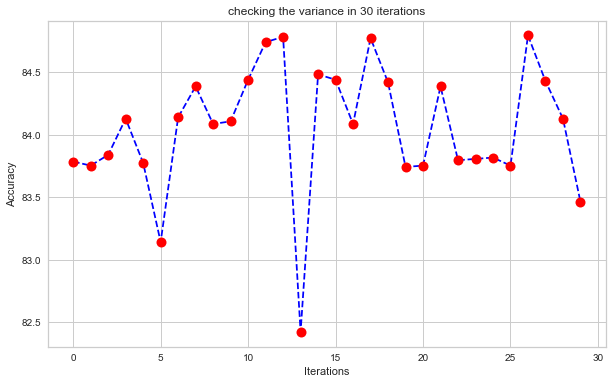

{'SVM': [82.4146953405018,
  83.61690185145926,
  81.63136202413024,
  82.4146953405018,
  82.31708194227356,
  89.87092896669783,
  0.016111489137013758],
 'Hypertuned': [83.831541218638,
  85.21377373566703,
  81.0034535633573,
  83.831541218638,
  83.58993038653384,
  90.49963522797498,
  0.011916120052337647],
 'Pca': [82.54910394265234,
  83.60669452823483,
  80.85706994295197,
  82.54910394265234,
  82.39399322864223,
  91.04546780255289,
  0.012255919774373372],
 'FImp': [83.84802867383513,
  85.11320327704819,
  82.31620049944522,
  83.84802867383513,
  83.71025263707661,
  90.56141572030317,
  0.01320926586786906],
 'Permutations': [84.05340501792116,
  85.4467932123978,
  81.18949121147767,
  84.05340501792116,
  83.83000883225962,
  90.94607629558455,
  0.013158713181813558]}

In [189]:

X = dataset[['caa','sex','thalachh','thall','oldpeak','cp','slp','trtbps','exng']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Permutations'] = result
dict_SV


## Sequential Forward Selection

In [190]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC()
sfs = SFS(svc, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(2, 9, 10, 11, 12)
('2', '9', '10', '11', '12')
CV Score:
0.8298469387755102


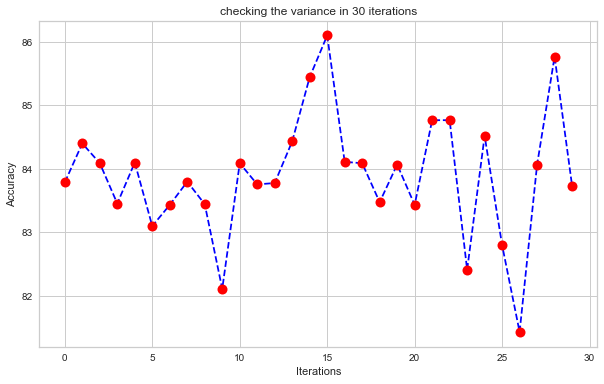

In [191]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_SV['SBS'] = result



In [192]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC()
sfs = SFS(svc, 
          k_features=9, 
          forward=True, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(0, 1, 2, 3, 4, 7, 9, 11, 12)
('0', '1', '2', '3', '4', '7', '9', '11', '12')
CV Score:
0.821513605442177


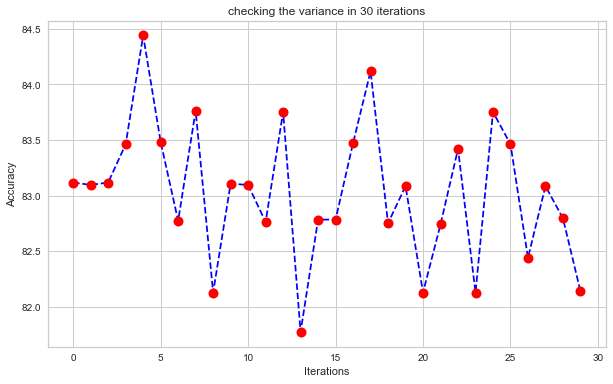

In [193]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_SV['SFS'] = result



## RFE

In [194]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

model=RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10, step=1, verbose=2)
rfe = rfe.fit(X_train, y_train)
rfe.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


array([ True, False,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True])

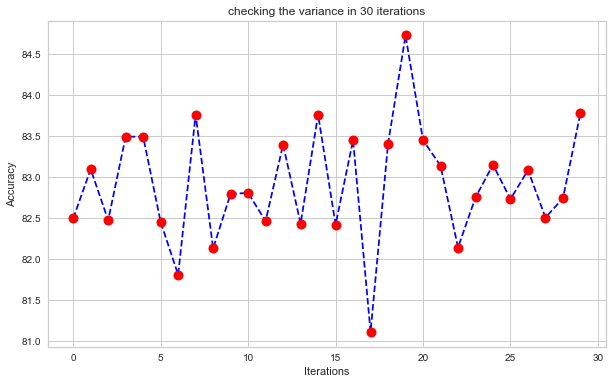

In [195]:
#'age sex cp trtbps chol fbs restecg thalachh exng oldpeak slp caa thall output'
X = dataset[['age','cp','trtbps','chol','thalachh','exng','sex','oldpeak','caa','thall']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['RFE'] = result

## K-means

In [196]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
X = dataset.iloc[:, 0:-1].values
y_old = dataset.iloc[:, -1].values

scaled_features = standardise(X)


model = KMeans()
#visualizer = KElbowVisualizer(model, k=(1,12)).fit(scaled_features)
#visualizer.show()

In [197]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(scaled_features)

In [198]:
y= kmeans.predict(scaled_features)

In [199]:
df = pd.DataFrame(scaled_features , columns= ['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall'])
#df['Cluster'] = y
#df['actual'] = y_old
df.head()

age       sex        cp    trtbps      chol       fbs   restecg  \
0  0.949794  0.682656  1.976470  0.764066 -0.261285  2.389793 -1.002541   
1 -1.928548  0.682656  1.005911 -0.091401  0.067741 -0.418446  0.901657   
2 -1.485726 -1.464866  0.035352 -0.091401 -0.822564 -0.418446 -1.002541   
3  0.174856  0.682656  0.035352 -0.661712 -0.203222 -0.418446  0.901657   
4  0.285561 -1.464866 -0.935208 -0.661712  2.080602 -0.418446  0.901657   

   thalachh      exng   oldpeak       slp       caa     thall  
0  0.018826 -0.698344  1.084022 -2.271182 -0.714911 -2.147955  
1  1.636979 -0.698344  2.118926 -2.271182 -0.714911 -0.513994  
2  0.980971 -0.698344  0.307844  0.979514 -0.714911 -0.513994  
3  1.243374 -0.698344 -0.209608  0.979514 -0.714911 -0.513994  
4  0.587366  1.431958 -0.382092  0.979514 -0.714911 -0.513994

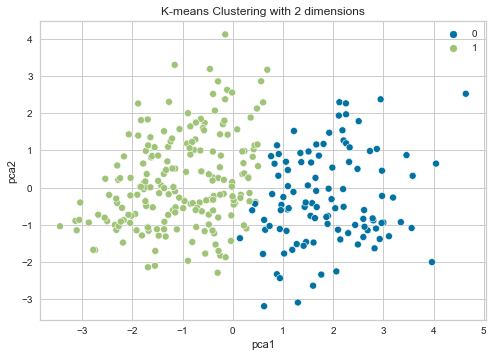

In [200]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(scaled_features)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

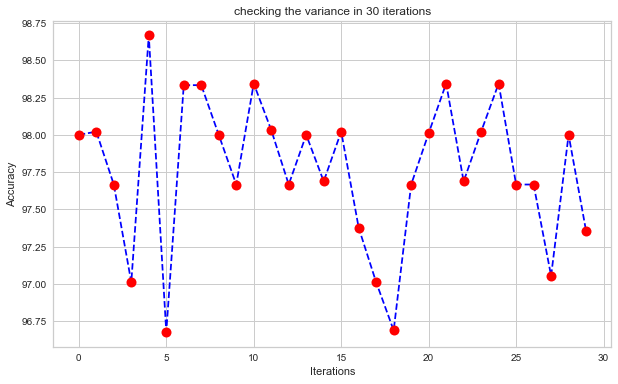

In [201]:

scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans'] = result

## Kmeans +FIMP


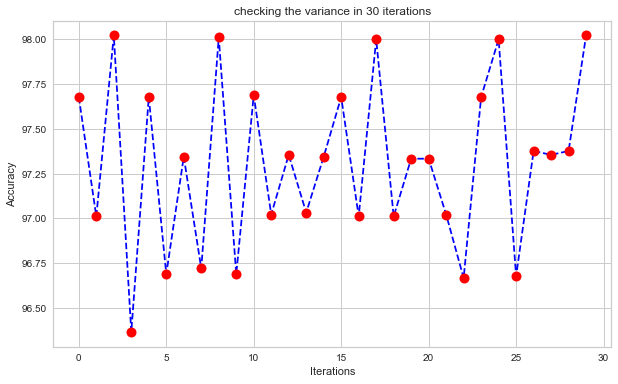

[97.30609318996416,
 97.50662573713099,
 96.33049540599556,
 97.30609318996416,
 97.2641792399293,
 99.78780244146213,
 0.009984222253163654]

In [202]:
X = dataset[['caa','sex','thalachh','thall','oldpeak','cp','slp','trtbps','exng']].values
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result

In [203]:
import shap
shap.initjs()

In [204]:
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

# compute SHAP values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)


[14:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


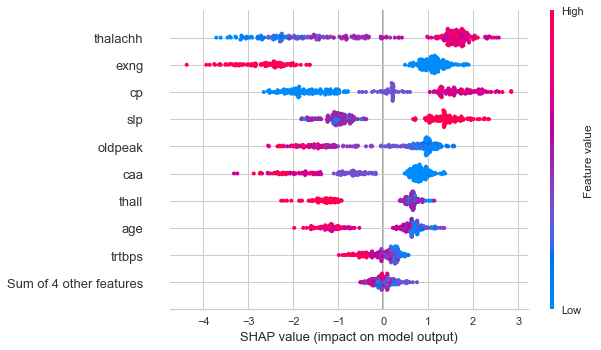

In [205]:
shap.plots.beeswarm(shap_values)

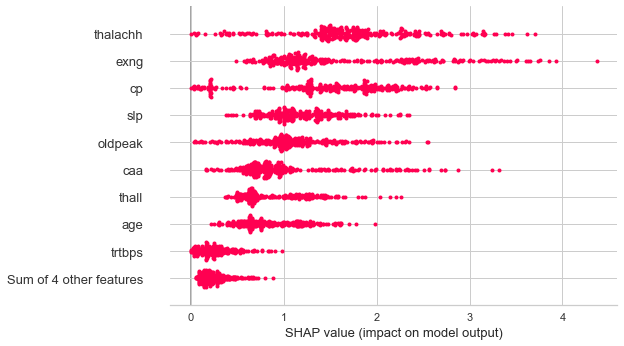

In [206]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

## kmeans+ shap important features

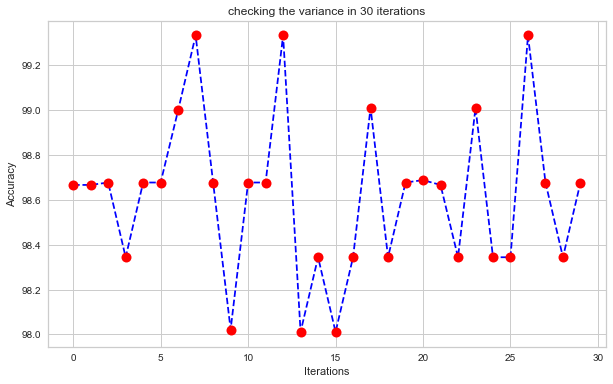

In [207]:
X = dataset[['caa','thalachh','oldpeak','cp','slp','exng','thall','age']].values
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans+Shap'] = result

In [208]:
df_dict = pd.DataFrame.from_dict(dict_SV,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM           82.414695  83.616902    81.631362  82.414695  82.317082   
Hypertuned    83.831541  85.213774    81.003454  83.831541  83.589930   
Pca           82.549104  83.606695    80.857070  82.549104  82.393993   
FImp          83.848029  85.113203    82.316200  83.848029  83.710253   
Permutations  84.053405  85.446793    81.189491  84.053405  83.830009   
SBS           83.888889  85.010257    82.983346  83.888889  83.793239   
SFS           83.032616  84.067829    81.054513  83.032616  82.843773   
RFE           82.915412  84.049662    80.692393  82.915412  82.693599   
kmeans        97.767384  97.944603    97.277871  97.767384  97.743265   
kmeans+Shap   98.620072  98.709353    98.826768  98.620072  98.618027   

                    Roc  CPU_time  
SVM           89.870929  0.016111  
Hypertuned    90.499635  0.011916  
Pca           91.045468  0.012256  
FImp          90.561416  0.013209  
Permutations  90.946076  0.013159  
SBS           90.814696  0.012927  
SFS           89.941649  0.012583  
RFE           90.418062  0.012933  
kmeans        99.906549  0.010171  
kmeans+Shap   99.955169  0.005918

In [210]:
#df_dict.to_excel('xl_result/SVM_heart1_30.xlsx')

In [4]:
#df_dict =  pd.read_excel('xl_result/SVM_heart1_30.xlsx',index_col=0)
#df_dict

In [3]:
# Adding Number of features
df_dict['no_of_features'] = [13,13,'4 components',6,9,9,5,10,13,8]
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM           82.414695  83.616902    81.631362  82.414695  82.317082   
Hypertuned    83.831541  85.213774    81.003454  83.831541  83.589930   
Pca           82.549104  83.606695    80.857070  82.549104  82.393993   
FImp          83.848029  85.113203    82.316200  83.848029  83.710253   
Permutations  84.053405  85.446793    81.189491  84.053405  83.830009   
SBS           83.888889  85.010257    82.983346  83.888889  83.793239   
SFS           83.032616  84.067829    81.054513  83.032616  82.843773   
RFE           82.915412  84.049662    80.692393  82.915412  82.693599   
kmeans        97.767384  97.944603    97.277871  97.767384  97.743265   
kmeans+Shap   98.620072  98.709353    98.826768  98.620072  98.618027   

                    Roc  CPU_time no_of_features  
SVM           89.870929  0.016111             13  
Hypertuned    90.499635  0.011916             13  
Pca           91.045468  0.012256   4 components  
FImp          90.561416  0.013209              6  
Permutations  90.946076  0.013159              9  
SBS           90.814696  0.012927              9  
SFS           89.941649  0.012583              5  
RFE           90.418062  0.012933             10  
kmeans        99.906549  0.010171             13  
kmeans+Shap   99.955169  0.005918              8